In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control
import scipy.signal

# Problem with Ideal Filtering

* Good
    * No time delay, exactly removed undesired frequencies (like noise)
   
* Bad
    * You need the entire data set ahead of time (unfortunately you can't see the future)

# Non-Ideal Filtering

* Good: 
    * It works in real time
    
* Bad:
    * Doesn't completely elim freq you don't like, just reduces them (attenuate)
    
* Butter filter:
    * flat in pass band
    * gradual attenuation
    
* Elliptic filter:
    * bad: ripple in pass band
    * good: spike of attenuation, attenurates quickly, can target frequencies
    * bad: stop band goes to fixed attenuation level at high frequencies

In [2]:
def compare_lowpass_filters(t, u, noise, filters, rp, rs, fp, fs, fpass_lim, fstop_lim, tlim):
    """
    @param t: time
    @param u: true input that we want to get back after filtering noisy version
    @param noise: noise to add to input before filtering
    @param filters: dictionary of cut frequncies for filters by name e.g. {'ideal': 1, 'butter 1', 2}
    @param rp: allowable pass band ripple
    @param rs: stop band attenuation
    @param fp: pass band frequency
    @param fs: stop band frequency
    @param fpass_lim: pass band limits
    @param fstop_lim: frequency limits
    @param tlim: time axis for plotting (e.g. [0, 1])
    """

    dt = t[1] - t[0]

    u_noisy = u + noise
    
    s = control.tf([1, 0], [1])
    f = np.logspace(np.log10(fpass_lim[0]), np.log10(fstop_lim[1]), 10000)
    omega = 2*np.pi*f

    def nonideal(N, f_cut, filt_type, t, u, rp=0.1, rs=20):
        wc = f_cut*2*np.pi
        if filt_type =='elliptic':
            G = control.tf(*scipy.signal.ellip(N=N, rp=rp, rs=rs, Wn=wc, analog='True'))
        elif filt_type == 'butter':
            G = control.tf(*scipy.signal.butter(N=N, Wn=wc, analog='True'))
        else:
            raise ValueError('unknown filter type: ', + filt_type)
        #mag, phase, _ = control.bode(G, omega=omega)
        # could call bode here, but odd unwrap issue with elliptic filters
        res = G.horner(1j*omega)[0, 0, :]
        mag = np.abs(res)
        phase = np.unwrap(np.angle(res), period=np.pi) # unwrap fixed with period=pi
        res = control.forced_response(sys=G, T=t, U=u)
        y = res.y[0, :]
        delay = -phase/omega
        return {
            'G': G,
            'mag_dB': 20*np.log10(mag),
            'phase': phase,
            'delay': delay,
            'y': y
        }

    data = {}
    for k in filters.keys():
        filt = filters[k]
        if filt['type'] == 'ideal':
            ak = np.fft.ifft(u_noisy)
            freq = np.fft.fftfreq(len(u_noisy), dt)
            ak_ideal = np.copy(ak)
            ak_ideal[np.abs(freq) > filt['f_cut']] = 0
            y_ideal = np.real(np.fft.fft(ak_ideal)) # imag part should be zero
            data['ideal'] = {
                'y': y_ideal
            }
        elif filt['type'] == 'butter':
            data[k] = nonideal(N=filt['order'], f_cut=filt['f_cut'], filt_type='butter', t=t, u=u)
        elif filt['type'] == 'elliptic':
            data[k] = nonideal(N=filt['order'], f_cut=filt['f_cut'], filt_type='elliptic', t=t, u=u,
                               rp=filt['rp'], rs=filt['rs'])
        else:
            raise ValueError('unknown filter type {:s}'.format(filt['type']))

    for k in data.keys():
        if 'G' in data[k].keys():
            print(k, data[k]['G'])

    plt.figure()
    plt.title('filtered data comparison')
    plt.plot(t, u_noisy, '.', label='noisy data', alpha=0.1)
    plt.plot(t, u, '--', label='true')
    for k in data.keys():
        plt.plot(t, data[k]['y'], label=k)
    plt.xlabel('t, sec')
    plt.ylabel('y')
    plt.grid()
    plt.legend()
    plt.gca().set_xlim(tlim)

    for band, lim, param in zip(['pass', 'stop'], [fpass_lim, fstop_lim], [rp, rs]):
        plt.figure()
        plt.title('bode mag, {:s} band'.format(band))
        plt.xlabel('f, Hz')
        plt.ylabel('|G(iw)|, dB')
        view = np.where(np.logical_and(f >= lim[0], f <= lim[1]))
        for k in data.keys():
            if 'mag_dB' in data[k].keys():
                plt.semilogx(f[view], data[k]['mag_dB'][view], label=k)
        if band == 'pass':
            plt.semilogx(f, np.ones(len(f))*-rp, 'k--', label='band pass ripple')
            plt.axvline(x=fp, color='g')
        elif band == 'stop':
            plt.semilogx(f, np.ones(len(f))*-rs, 'k--', label='stop band attenuation')
            plt.axvline(x=fs, color='g')
        plt.gca().set_xlim(lim)
        plt.legend()
        plt.grid()

    plt.figure()
    plt.title('bode phase')
    for k in data.keys():
        if 'phase' in data[k].keys():
            plt.semilogx(f, np.rad2deg(data[k]['phase']), label=k)
    plt.xlabel('f, Hz')
    plt.ylabel('angle G(iw), deg')
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title('time delay')
    plt.xlabel('f, Hz')
    plt.ylabel('delay, sec')
    for k in data.keys():
        if 'delay' in data[k].keys():
            plt.semilogx(f, data[k]['delay'], label=k)
    plt.legend()
    plt.grid()
    return locals()

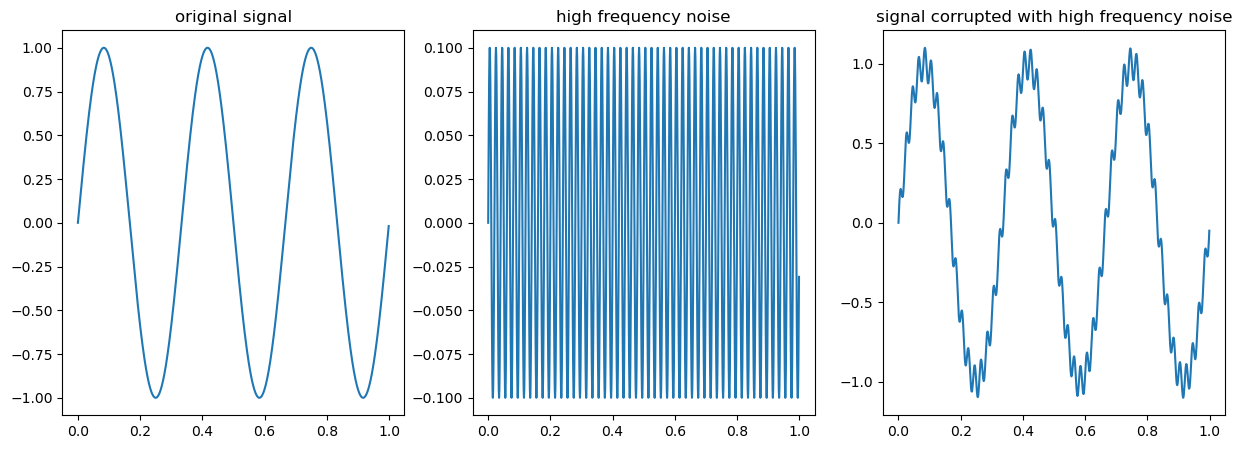

In [3]:
t = np.arange(0, 1, 0.001)
u = np.sin(2*np.pi*3*t)
#u = np.where(t > 0.2, 1, 0)
noise = 0.1*np.sin(2*np.pi*50*t)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('original signal')
plt.plot(t, u)

plt.subplot(132)
plt.title('high frequency noise')
plt.plot(t, noise)

plt.subplot(133)
plt.title('signal corrupted with high frequency noise')
plt.plot(t, u + noise)

In [6]:
10**(-40/20)

0.01

butter 3 
                2.297e+06
-----------------------------------------
s^3 + 263.9 s^2 + 3.482e+04 s + 2.297e+06

ellip 3 
        18.25 s^2 + 9.231e+06
--------------------------------------
s^3 + 353 s^2 + 8.08e+04 s + 9.231e+06



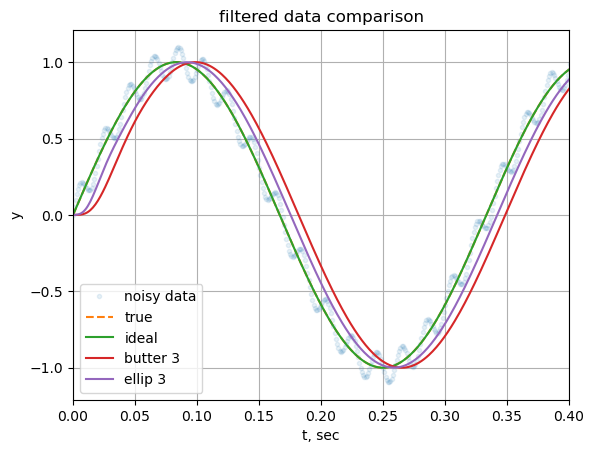

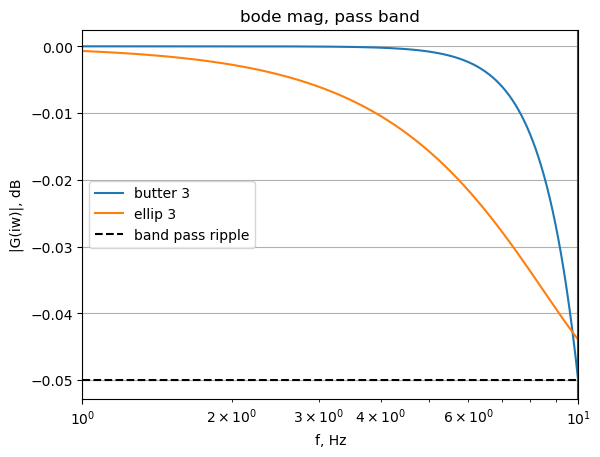

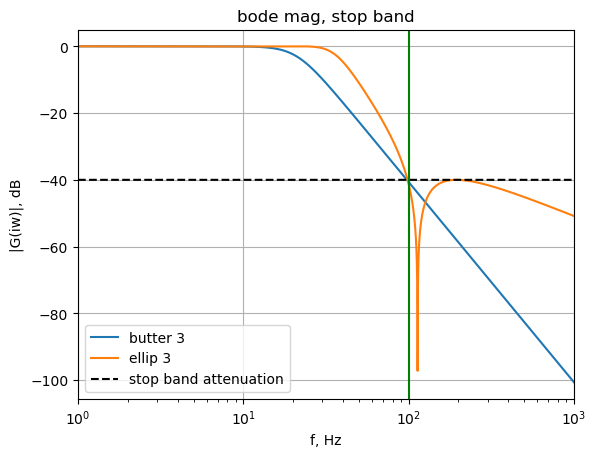

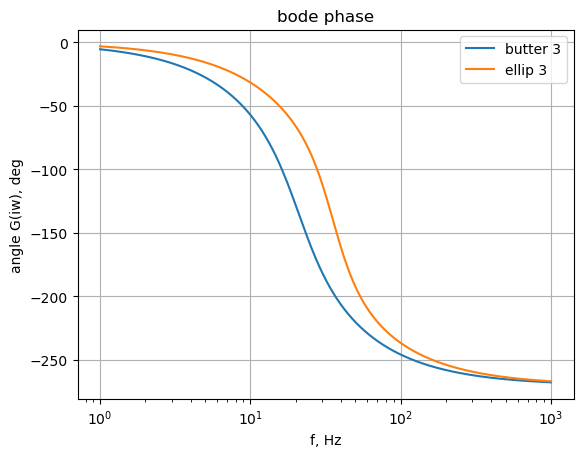

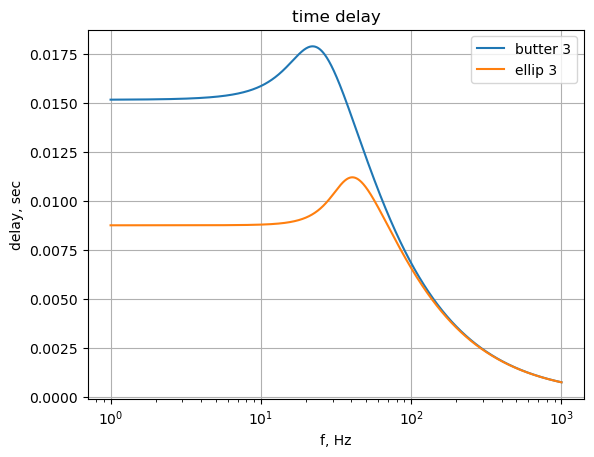

In [4]:
# example design a filter with -40 dB attenuation at frequencies over 100 Hz
# maximum ripple in the pass band (less than 10 Hz) of 0.05 dB
res = compare_lowpass_filters(
    t=t,
    u=u,
    noise=noise,
    filters = {
        'ideal': {'type': 'ideal', 'f_cut': 49.9}, # noise is at 50, can cut right before
        'butter 3': {'type': 'butter', 'f_cut': 21, 'order': 3},
        'ellip 3': {'type': 'elliptic', 'f_cut': 25, 'order': 3, 'rp': 0.05, 'rs': 40},
    },
    tlim=[0, 0.4], # time axis for plotting,
    fpass_lim=[1, 10], # frequncy limits
    fstop_lim=[1, 1000], # frequncy limits
    rp=0.05,
    rs=40,
    fp=10,
    fs=100
)